<a href="https://colab.research.google.com/github/Bziukiewicz/tests/blob/master/wpw_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalacja oraz import bibliotek

In [1]:
pip install ecg_plot


In [2]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.9 MB/s eta 0:00:00


In [3]:
pip install --upgrade keras==3.3.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras.preprocessing.sequence import pad_sequences
import scipy.io
import csv
import ecg_plot
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
import plotly.express as px
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Załadowanie danych z EKG dla pacjentów zdrowych, oraz zdiagnozowanych z WPW

In [9]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [10]:
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)

In [11]:
wpw_dir = "/content/drive/MyDrive/wpw_dataset"
wpw = import_ecg_data(wpw_dir)
normal_dir= '/content/drive/MyDrive/only_sinus_smaller'
normal=import_ecg_data(normal_dir)

Starting ECG import..


100%|██████████| 320/320 [00:07<00:00, 45.06it/s] 


Finished!
Starting ECG import..


100%|██████████| 1028/1028 [01:22<00:00, 12.52it/s]

Finished!


### Przykłady EKG dla pacjentów zdrowych, oraz ze zdiagnozowanym WPW

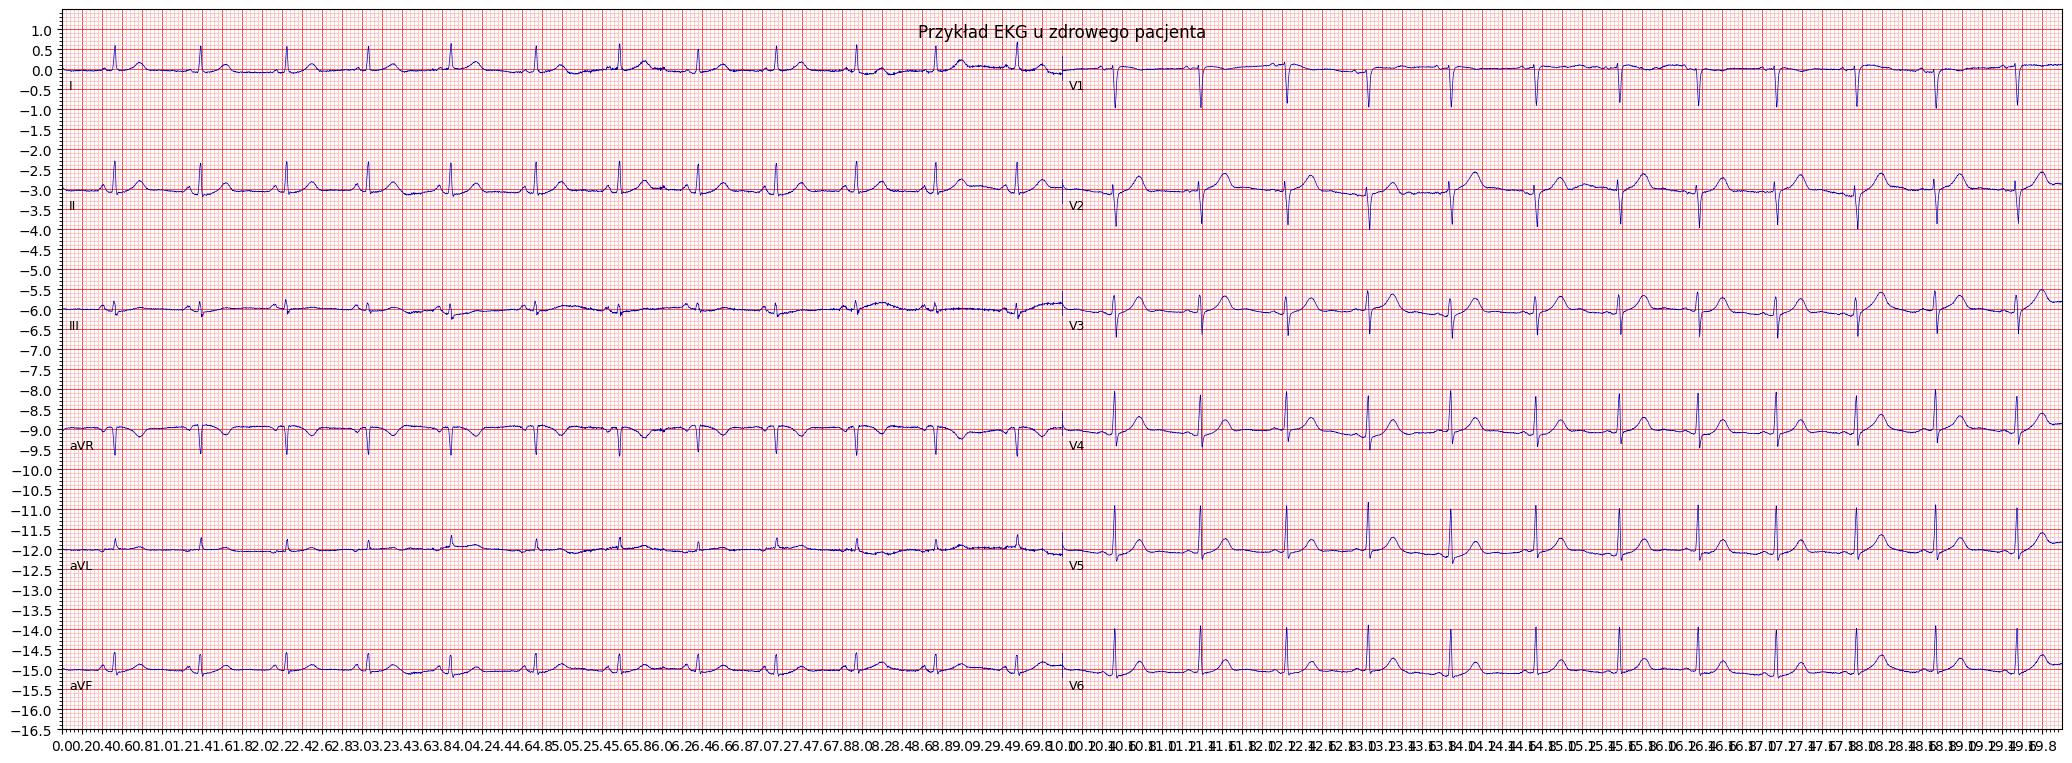

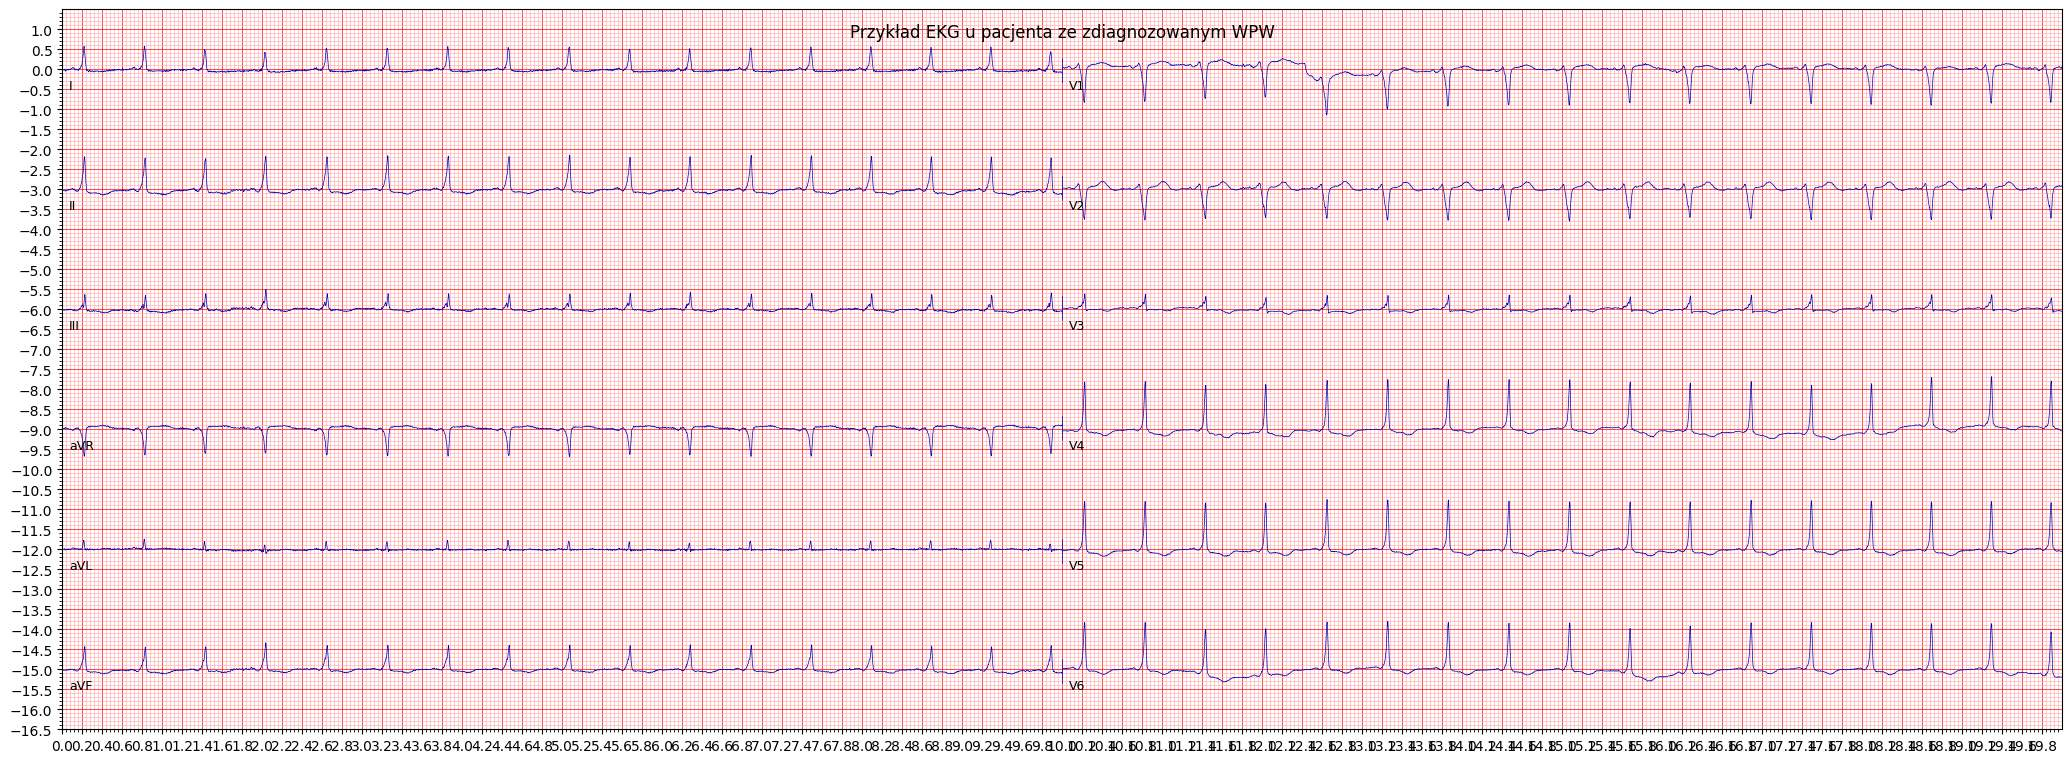

In [ ]:
ecg_data = load_challenge_data('/content/drive/MyDrive/only_sinus_smaller/JS41028.mat')
ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='Przykład EKG u zdrowego pacjenta')
ecg_plot.show()

ecg_data = load_challenge_data('/content/drive/MyDrive/wpw_dataset/E03231.mat')
ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='Przykład EKG u pacjenta ze zdiagnozowanym WPW')
ecg_plot.show()

### Załądowanie pozostałych danych z pliku .hea

In [ ]:
import scipy.io
import csv


folder_path = "/content/drive/MyDrive/wpw_dataset"

# Funkcja do otwierania plików MAT i HEA oraz łączenia danych w jednym wierszu
def process_files(mat_file_path, hea_file_path):

    mat_data = scipy.io.loadmat(mat_file_path)
    ekg_data = mat_data['val']


    with open(hea_file_path, 'r') as file:
        data = file.readlines()
        age = None
        sex = None
        diagnosis = None
        for line in data:
            if line.startswith('#Age:'):
                age = line.split(': ')[1].strip()
            elif line.startswith('#Sex:'):
                sex = line.split(': ')[1].strip()
            elif line.startswith('#Dx:'):
                diagnosis = line.split(': ')[1].strip()

    return ekg_data, age, sex, diagnosis

# Funkcja do zapisywania danych do pliku CSV
def save_to_csv(data, csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

# Lista do przechowywania wszystkich danych EKG, metadanych i diagnoz
all_data = []

# Iteracja przez pliki w folderze
for file_name in os.listdir(folder_path):
    if file_name.endswith('.mat'):
        mat_file_path = os.path.join(folder_path, file_name)
        hea_file_path = os.path.join(folder_path, file_name.replace('.mat', '.hea'))

        ekg_data, age, sex, diagnosis = process_files(mat_file_path, hea_file_path)


        all_data.append([file_name] + [age, sex, diagnosis] + [ekg_data])


csv_file_path = "wszystkie_dane1.csv"
save_to_csv(all_data, csv_file_path)

In [ ]:
df= pd.read_csv('/content/wszystkie_dane1.csv', names=['wiek','Płeć' ,'Diagnoza', 'dane'])

### Rozkład danych ze względu na wiek i płeć pacjenta

In [ ]:
fig = px.histogram(df, x='wiek', title='Histogram rozkładu wieku',
                   labels={'wiek': 'Wiek', 'count': 'Liczba przypadków'})

fig.show()
fig.write_html("wykres_rozkladu_wieku.html")

In [ ]:
df['Płeć'] = df['Płeć'].replace('M', 'Male')
df['Płeć'] = df['Płeć'].replace('male', 'Male')
fig = px.histogram(df, x='Płeć', title='Histogram rozkładu płci',
                   labels={'Płeć': 'Płeć', 'count': 'Liczba przypadków'})

fig.show()
fig.write_html("wykres_rozkladu_plci.html")

### Przygotowanie danych do pracy

In [ ]:
!pip install neurokit2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 3.1 MB/s eta 0:00:00


***Preprocessing***
1. Filtrowanie: W funkcji process_ecgs, sygnały EKG są najpierw czyszczone za pomocą funkcji nk.ecg_clean(), która wykorzystuje metody neurokit2 do eliminacji szumów i artefaktów z sygnału.

2. Normalizacja: Proces segmentacji i obliczania mediany dla sygnałów odgrywa tutaj funkcje normalizacji, ponieważ mediany są obliczane dla każdego sygnału EKG.

3. Segmentacja: Segmentacja jest wykonywana za pomocą funkcji nk.ecg_segment(), która dzieli sygnał na poszczególne cykle serca na podstawie znalezionych szczytów (r_peaks).

In [ ]:

import neurokit2 as nk  # Import neurokit2 as nk

def resample_beats(beats):
    # Funkcja resample_beats dokonuje resamplingu zbioru szczytów do długości 250 próbek
    return np.array([np.nan_to_num(signal.resample(np.asarray(i), 250)) for i in beats])

def median_beat(beat_dict):
    # Funkcja median_beat oblicza medianę zbioru szczytów dla każdego słownika w zestawie
    beats = [entry['Signal'] for entry in beat_dict.values()]
    rsmp_beats = resample_beats(beats)
    return np.median(rsmp_beats, axis=0)

def process_ecgs(raw_ecg):
    # Funkcja process_ecgs przetwarza surowe dane EKG
    processed_ecgs = []
    for lead_set in tqdm(raw_ecg):
        twelve_leads = []
        leadII = lead_set[1]
        leadII_clean = nk.ecg_clean(leadII, sampling_rate=500, method="neurokit")  # Czyszczenie sygnału EKG
        r_peaks = nk.ecg_findpeaks(leadII_clean, sampling_rate=500, method="neurokit", show=False)  # Znajdowanie szczytów
        for lead in lead_set:
            try:
                beats = nk.ecg_segment(lead, rpeaks=r_peaks['ECG_R_Peaks'], sampling_rate=500, show=False)  # Segmentacja sygnału EKG
                med_beat = median_beat(beats)  # Obliczanie mediany dla sygnałów
            except:
                med_beat = np.ones(250) * np.nan
            twelve_leads.append(med_beat)
        processed_ecgs.append(twelve_leads)
    return np.array(processed_ecgs)

wpw_ecg= process_ecgs(wpw)

 56%|█████▌    | 89/160 [01:35<01:01,  1.15it/s]/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 97%|█████████▋| 155/160 [02:24<00:05,  1.16s/it]/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
100%|██████████| 160/160 [02:27<00:00,  1.09it/s]


In [47]:
normal_ecg= process_ecgs(normal)

***Porównnie danych dla jednej próbki przed preprocessingiem i po***

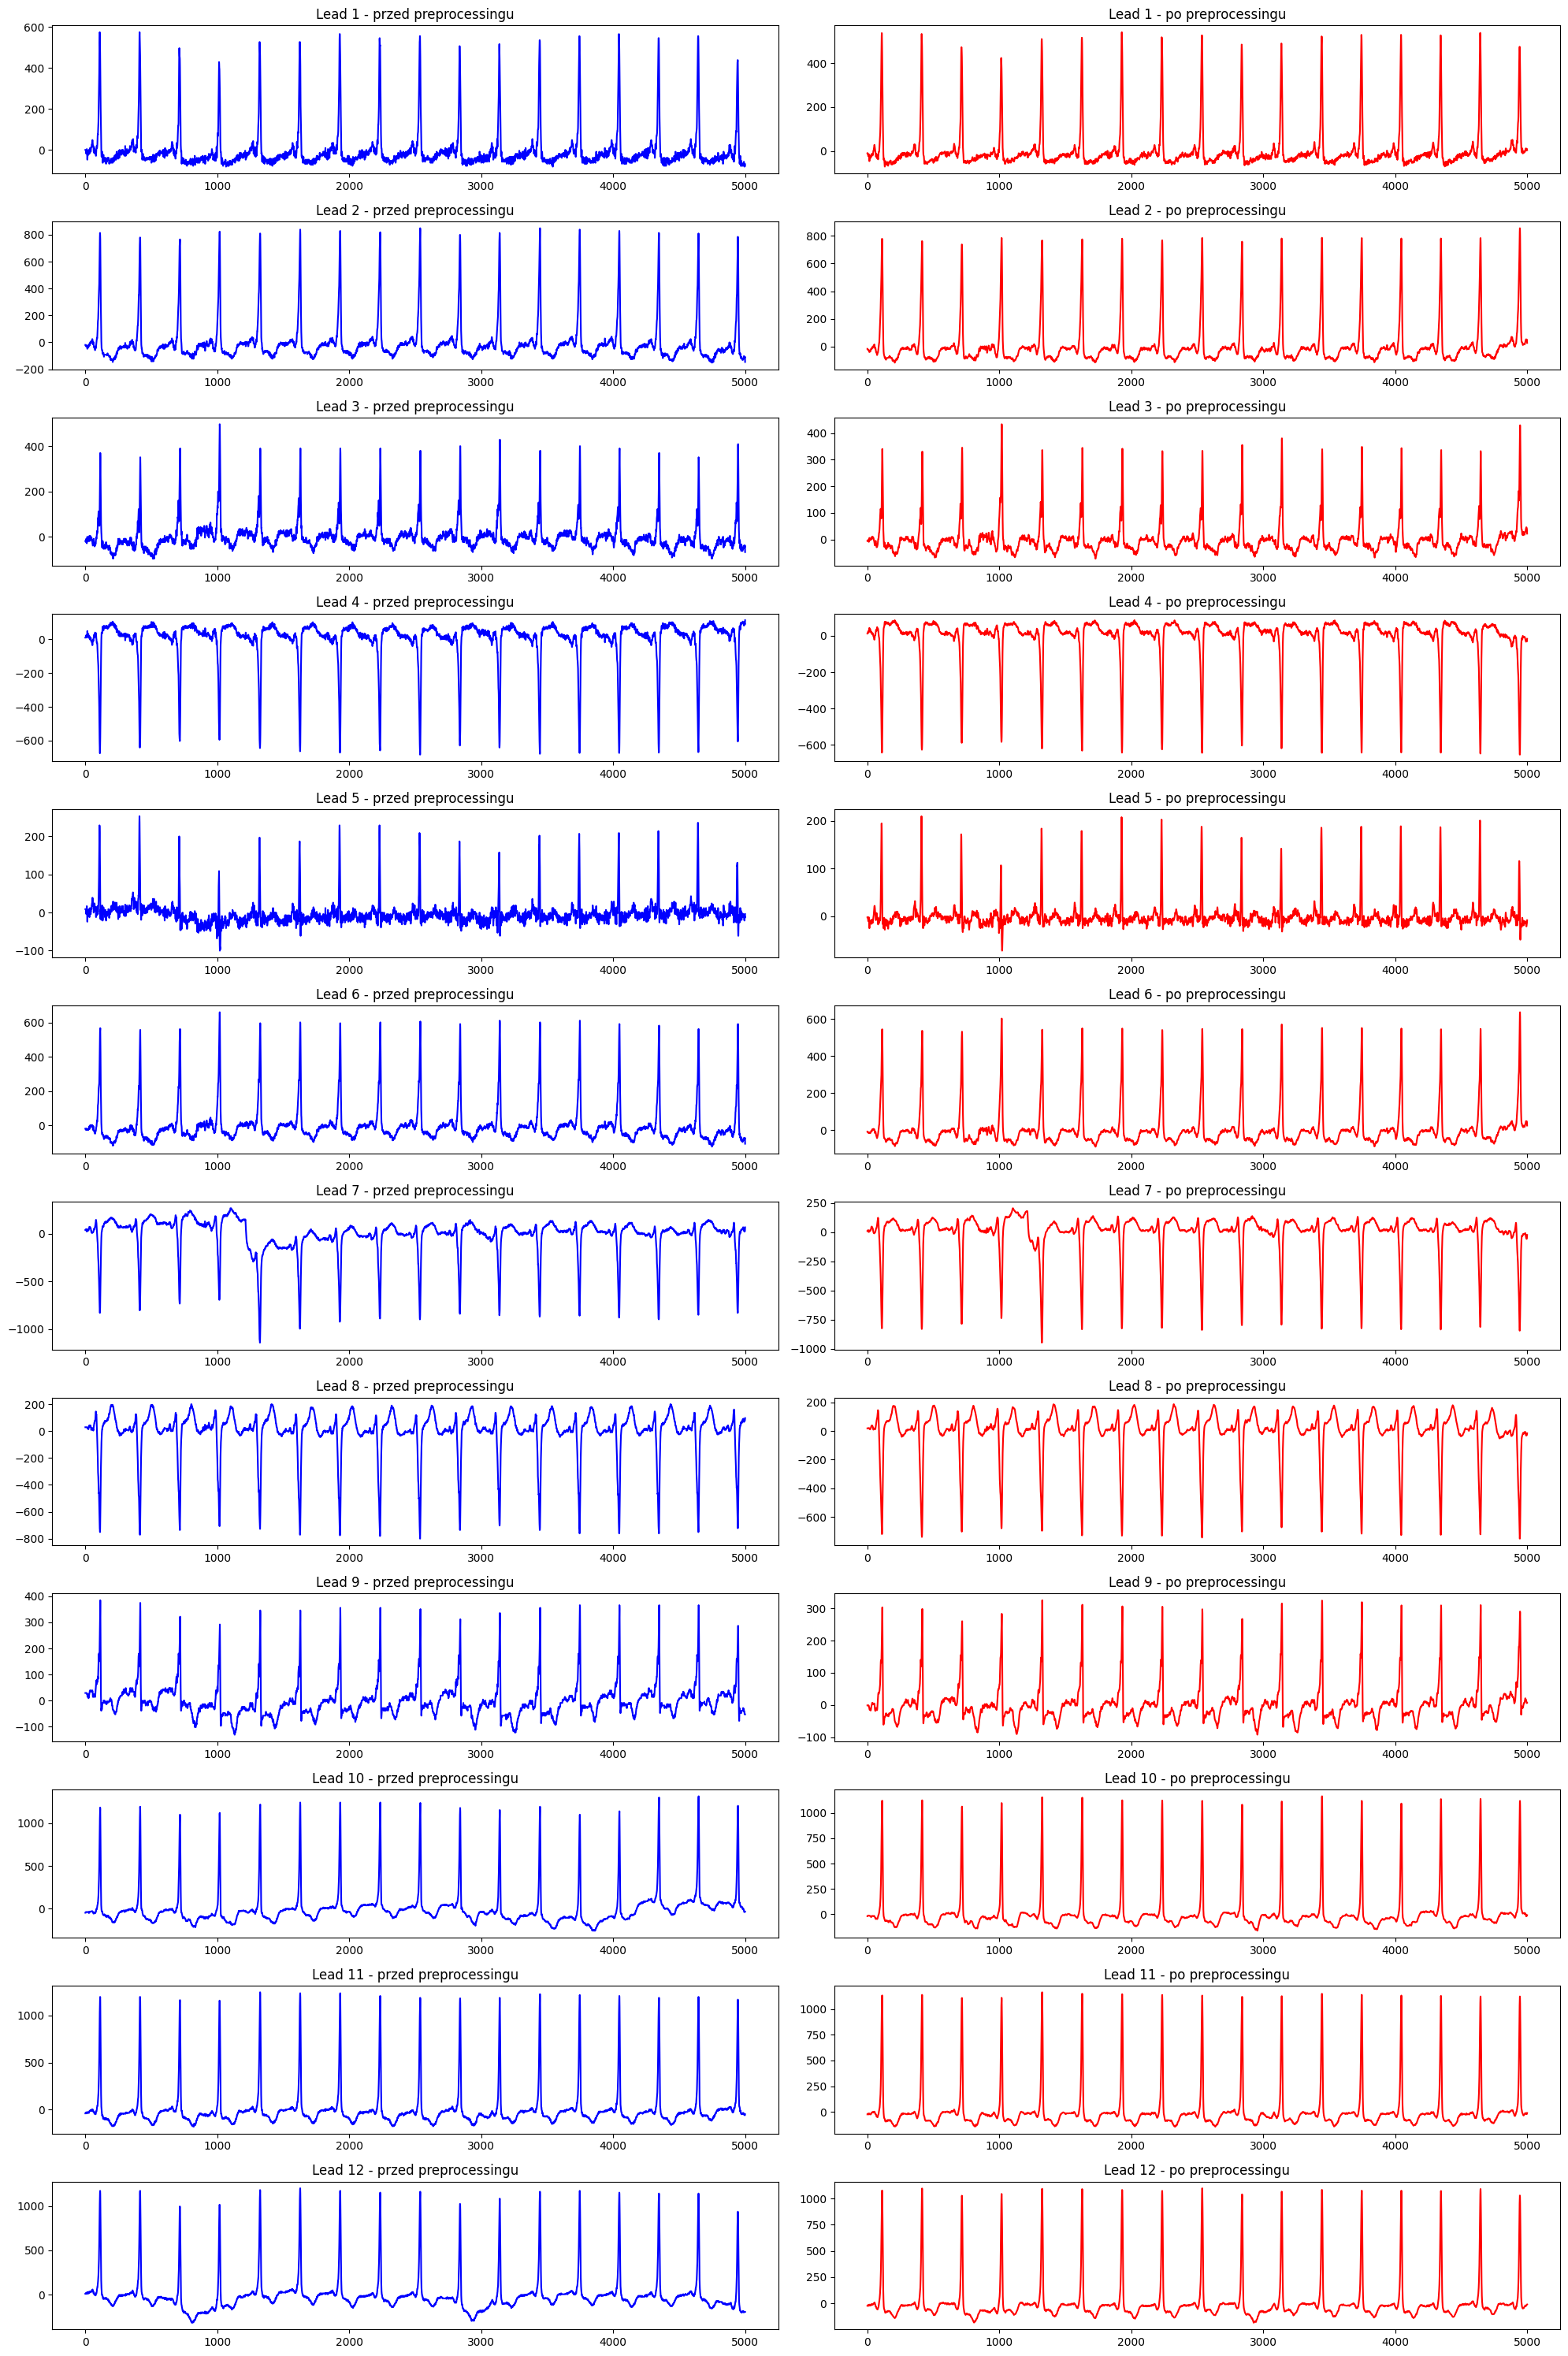

In [48]:

sample_index = 0
raw_sample = wpw[sample_index]
processed_sample = wpw_ecg[sample_index]


fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(20, 30))


for lead_index in range(12):

    raw_data = raw_sample[lead_index]
    processed_data = processed_sample[lead_index]


    axs[lead_index, 0].plot(raw_data, color='blue')
    axs[lead_index, 0].set_title(f'Lead {lead_index + 1} - przed preprocessingu')


    axs[lead_index, 1].plot(processed_data, color='red')
    axs[lead_index, 1].set_title(f'Lead {lead_index + 1} - po preprocessingu')


plt.tight_layout()


plt.show()

### Usuwanie wartości NAN
Jako, że wartości nan jest stosunkowo mało, usuwam całe próbki zawierające te wartości.

In [49]:
wpw_ecg[np.isnan(wpw_ecg)==True]

array([], dtype=int32)

In [ ]:
nan_indices = np.any(np.isnan(wpw_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [ 89 155]


In [ ]:
nan_indices = np.any(np.isnan(normal_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [509 510]


In [ ]:
wpw_ecg = np.delete(wpw_ecg, 89, axis=0)
wpw_ecg = np.delete(wpw_ecg, 155, axis=0)
normal_ecg = np.delete(normal_ecg, 509, axis=0)
normal_ecg = np.delete(normal_ecg, 510, axis=0)

In [ ]:
nan_indices = np.any(np.isnan(wpw_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [154]


In [ ]:
wpw_ecg = np.delete(wpw_ecg, 154, axis=0)

In [ ]:
nan_indices = np.any(np.isnan(normal_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [509]


In [ ]:
normal_ecg = np.delete(normal_ecg, 509, axis=0)

In [ ]:
np.isnan(wpw_ecg).sum()

0

###Podział na dane testowe i treningowe, oraz dodanie wartości target

In [50]:
wpw_ecg = np.moveaxis(wpw_ecg, 1, -1)
normal_ecg = np.moveaxis(normal_ecg, 1, -1)

In [51]:
wpw_traget= np.ones(wpw_ecg.shape[0])
normal_traget= np.zeros(normal_ecg.shape[0])

In [52]:
wpw_ecg.shape

(160, 5000, 12)

In [53]:
wpw_traget.shape


(160,)

In [54]:
# podział zbiorów na treningowy i testowy 30% to zbiór testowy
wpw_train = wpw_ecg[:93]
wpw_test = wpw_ecg[117:]
wpw_val = wpw_ecg[93:117]
wpw_target_train = wpw_traget[:93]
wpw_target_test = wpw_traget[117:]
wpw_target_val = wpw_traget[93:117]
print(wpw_train .shape)
print(wpw_test.shape)
print(wpw_val.shape)
normal_train = normal_ecg[:93]
normal_test = normal_ecg[117:157]
normal_val=normal_ecg[93:117]
print(normal_train .shape)
print(normal_test.shape)
print(normal_val.shape)
normal_target_train = normal_traget[:93]
normal_target_test = normal_traget[117:157]
normal_target_val= normal_traget[93:117]

(93, 5000, 12)
(43, 5000, 12)
(24, 5000, 12)
(93, 5000, 12)
(40, 5000, 12)
(24, 5000, 12)


In [55]:
X_train = np.vstack([normal_train,wpw_train])
y_train = np.hstack([normal_target_train,wpw_target_train])

In [56]:
X_test = np.vstack([normal_test,wpw_test])
y_test = np.hstack([normal_target_test,wpw_target_test])

In [57]:
X_val= np.vstack([normal_val, wpw_val])
y_val= np.hstack([normal_target_val, wpw_target_val])

In [58]:
X_train.shape

(186, 5000, 12)

In [ ]:
y_train.shape

(186,)

In [63]:
X_test.shape

(83, 5000, 12)

### Modele uczenia maszynowego

***Model lasów losowych***

In [59]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [64]:
from sklearn.metrics import accuracy_score

X_train_flatten = np.reshape(X_train, (186, -1))
X_test_flatten = np.reshape(X_test, (83, -1))

model_random_tree = classifier = RandomForestClassifier()
model_random_tree.fit(X_train_flatten, y_train)

y_pred_random_tree = model_random_tree.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_random_tree))


0.8433734939759037


In [61]:
param_grid = {
    'n_estimators': [1, 5, 10, 15, 20, 30,50 ,100, 200],
    'max_depth': [None, 1, 3, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['entropy', 'gini']
}

grid_search = GridSearchCV(estimator=model_random_tree,
                     param_grid=param_grid,
                     scoring='roc_auc')

grid_search.fit(X_train_flatten, y_train)

best_parameters = grid_search.best_params_
print(best_parameters)

KeyboardInterrupt: 

In [ ]:
model_random_tree = RandomForestClassifier(**best_parameters)
model_random_tree.fit(X_train_flatten, y_train)
y_pred_random_tree = model_random_tree.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_random_tree))

0.9125


In [67]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.graph_objects as go
cm = confusion_matrix(y_test, y_pred_random_tree)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig = plot_confusion_matrix(cm)
fig.write_html("random_tree_cm.html")

***Model Regresji logistycznej***

In [68]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_flatten, y_train)
y_pred_logistic_regression = logistic_regression_model.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_logistic_regression))

cm = confusion_matrix(y_test, y_pred_logistic_regression)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig = plot_confusion_matrix(cm)

fig.write_html("cm_regression.html")

0.5903614457831325


***Model K-najbliższych sąsiadów***

In [69]:
from sklearn.neighbors import KNeighborsClassifier

kn_model = KNeighborsClassifier(n_neighbors=5)
kn_model.fit(X_train_flatten, y_train)
y_pred_kn = kn_model.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_kn))

cm = confusion_matrix(y_test, y_pred_kn)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig = plot_confusion_matrix(cm)
fig.write_html("cm_knn.html")

0.4819277108433735


### Modele uczenia głębokiego

***Model RNN- Rekurencyjna sieć neuronowa***

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, GRU, Lambda, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Definicja funkcji celu
def rnn_objective(params):
    rnn_model = Sequential()
    rnn_model.add(LSTM(units=params['units1'], input_shape=(250, 12), return_sequences=True))
    rnn_model.add(Dropout(params['dropout1']))
    rnn_model.add(LSTM(units=params['units2'], return_sequences=True))
    rnn_model.add(Dropout(params['dropout2']))
    rnn_model.add(LSTM(units=params['units3']))
    rnn_model.add(Dense(units=1, activation='sigmoid'))

    rnn_model.compile(optimizer='adamax',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Dopasowanie modelu
    history = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Zwrócenie wartości do minimalizacji (np. błąd walidacji)
    return -history.history['val_accuracy'][-1]  # Minimizujemy walidacyjną dokładność

# Definicja przestrzeni hiperparametrów
space = {
    'units1': hp.choice('units1', [32, 64, 128]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'units2': hp.choice('units2', [32, 64, 128]),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'units3': hp.choice('units3', [32, 64, 128])
}

# Uruchomienie optymalizacji bayesowskiej
trials = Trials()
best_params = fmin(fn=rnn_objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Najlepsze hiperparametry:", best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




100%|██████████| 10/10 [32:29<00:00, 194.95s/trial, best loss: -0.7291666865348816]
Najlepsze hiperparametry: {'dropout1': 0.24989025565609563, 'dropout2': 0.2735263487478834, 'units1': 0, 'units2': 1, 'units3': 2}


In [ ]:
best_rnn_model = Sequential()
best_rnn_model.add(LSTM(units=[32, 64, 128][best_params['units1']], input_shape=(250, 12), return_sequences=True))
best_rnn_model.add(Dropout(best_params['dropout1']))
best_rnn_model.add(LSTM(units=[32, 64, 128][best_params['units2']], return_sequences=True))
best_rnn_model.add(Dropout(best_params['dropout2']))
best_rnn_model.add(LSTM(units=[32, 64, 128][best_params['units3']]))
best_rnn_model.add(Dense(units=1, activation='sigmoid'))

best_rnn_model.compile(optimizer='adamax',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

history = best_rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5295 - loss: 0.6919 - val_accuracy: 0.4792 - val_loss: 0.6936
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.6888 - loss: 0.6416 - val_accuracy: 0.5625 - val_loss: 0.6863
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 812ms/step - accuracy: 0.6846 - loss: 0.6148 - val_accuracy: 0.5625 - val_loss: 0.7027
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - accuracy: 0.7764 - loss: 0.5305 - val_accuracy: 0.5417 - val_loss: 0.7333
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 527ms/step - accuracy: 0.7732 - loss: 0.4909 - val_accuracy: 0.6458 - val_loss: 0.7457
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 931ms/step - accuracy: 0.7808 - loss: 0.4862 - val_accuracy: 0.6250 - val_loss: 0.7454
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - accuracy: 0.8019 - loss: 0.4397 - val_accuracy: 0.6875 - val_loss: 0.7631
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8520 - loss: 0.3939 - val_accuracy: 0.6875 - val_loss: 0.7

In [ ]:
results=best_rnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {results[1]:.4f}')
print(f'Loss: {results[0]:.4f}')

Accuracy: 0.7000
Loss: 1.2725


In [ ]:
# Przewidywanie prawdopodobieństw dla danych testowych
y_pred_prob_rnn = best_rnn_model.predict(X_test)

# Konwersja prawdopodobieństw na indeksy klas
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)

y_pred_rnn

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step


array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
cm = confusion_matrix(y_test, y_pred_rnn)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig=plot_confusion_matrix(cm)
fig.write_html("cm_rnn.html")

In [71]:
from hyperopt import fmin, tpe, hp, Trials
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization

In [ ]:
def cnn_objective(params):
    model = Sequential()

    model.add(Conv1D(filters=params['filters1'], kernel_size=params['kernel_size1'], activation='relu', input_shape=(250, 12)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=params['filters2'], kernel_size=params['kernel_size2'], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=params['pool_size1']))
    model.add(Dropout(params['dropout1']))
    model.add(Conv1D(filters=params['filters3'], kernel_size=params['kernel_size3'], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=params['pool_size2']))
    model.add(Dropout(params['dropout2']))
    model.add(Flatten())
    model.add(Dense(units=params['units'], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout3']))
    model.add(Dense(units=1, activation='sigmoid'))


    model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    return -history.history['val_accuracy'][-1]


space = {
    'filters1': hp.choice('filters1', [64, 128]),
    'kernel_size1': hp.choice('kernel_size1', [5, 10]),
    'filters2': hp.choice('filters2', [64, 128]),
    'kernel_size2': hp.choice('kernel_size2', [10, 15]),
    'pool_size1': hp.choice('pool_size1', [2, 3]),
    'dropout1': hp.uniform('dropout1', 0, 0.3),
    'filters3': hp.choice('filters3', [128, 256]),
    'kernel_size3': hp.choice('kernel_size3', [3, 5, 7]),
    'pool_size2': hp.choice('pool_size2', [2, 3]),
    'dropout2': hp.uniform('dropout2', 0, 0.3),
    'units': hp.choice('units', [32, 64]),
    'dropout3': hp.uniform('dropout3', 0, 0.3)
}

trials = Trials()
best_params = fmin(fn=cnn_objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Najlepsze hiperparametry:", best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




100%|██████████| 10/10 [09:57<00:00, 59.79s/trial, best loss: -0.8541666865348816]
Najlepsze hiperparametry: {'dropout1': 0.07062766506684043, 'dropout2': 0.2753441225561425, 'dropout3': 0.15165416933494025, 'filters1': 0, 'filters2': 0, 'filters3': 1, 'kernel_size1': 0, 'kernel_size2': 1, 'kernel_size3': 1, 'pool_size1': 1, 'pool_size2': 0, 'units': 0}


In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)

In [72]:
best_model = Sequential()

best_model.add(Conv1D(filters=[64, 128][best_params['filters1']], kernel_size=[5, 10][best_params['kernel_size1']], activation='relu', input_shape=(250, 12)))
best_model.add(BatchNormalization())
best_model.add(Conv1D(filters=[64, 128][best_params['filters2']], kernel_size=[10, 15][best_params['kernel_size2']], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling1D(pool_size=[2, 3][best_params['pool_size1']]))
best_model.add(Dropout(best_params['dropout1']))
best_model.add(Conv1D(filters=[128, 256][best_params['filters3']], kernel_size=[3, 5, 7][best_params['kernel_size3']], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling1D(pool_size=[2, 3][best_params['pool_size2']]))
best_model.add(Dropout(best_params['dropout2']))
best_model.add(Flatten())
best_model.add(Dense(units=best_params['units'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_params['dropout3']))
best_model.add(Dense(units=1, activation='sigmoid'))


best_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
best_model.summary()

NameError: name 'best_params' is not defined

In [ ]:
history_cnn = best_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.5161 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5106 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5020 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5243 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5410 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4952 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5401 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.4872 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss:

In [ ]:
results_cnn=best_model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {results[1]:.4f}')
print(f'Loss: {results[0]:.4f}')

Accuracy: 0.7000
Loss: 1.2725


In [ ]:
# Przewidywanie prawdopodobieństw dla danych testowych
y_pred_prob = best_model.predict(X_test)

# Konwersja prawdopodobieństw na indeksy klas
y_pred_cnn = (y_pred_prob > 0.5).astype(int)

# Wyświetlenie przewidywanych klas
print(y_pred_cnn)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [73]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(250, 12)))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 14336, but received input with shape (None, 318208)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 5000, 12), dtype=int32)
  • training=True
  • mask=None

Nie użyłam callbacków ze względu na to , ze val_accuracy i val_los malały i rosły bardzo nieregularnie

In [ ]:
import plotly.express as px

# Stwórz DataFrame z historią treningu
history_df = pd.DataFrame(history.history)
epochs = range(1, len(history_df) + 1)

# Wygeneruj wykres za pomocą Plotly Express
fig = px.line(history_df, x=epochs, y='val_accuracy', title='Validation Accuracy vs. Epochs')
fig.update_xaxes(title='Epochs')
fig.update_yaxes(title='Validation Accuracy')
fig.show()

In [ ]:
import plotly.express as px

# Stwórz DataFrame z historią treningu
history_df = pd.DataFrame(history.history)
epochs = range(1, len(history_df) + 1)

# Wygeneruj wykres za pomocą Plotly Express
fig = px.line(history_df, x=epochs, y='val_loss', title='Validation Loss vs. Epochs')
fig.update_xaxes(title='Epochs')
fig.update_yaxes(title='Validation Loss')
fig.show()

In [ ]:
results=model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {results[1]:.4f}')
print(f'Loss: {results[0]:.4f}')

Accuracy: 0.8375
Loss: 0.4386


In [ ]:
# Przewidywanie prawdopodobieństw dla danych testowych
y_pred_prob = model.predict(X_test)

# Konwersja prawdopodobieństw na indeksy klas
y_pred_cnn = (y_pred_prob > 0.5).astype(int)

y_pred_cnn

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [ ]:
cm = confusion_matrix(y_test, y_pred_cnn)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig=plot_confusion_matrix(cm)
fig.write_html("cm_cnn.html")

In [ ]:
from tensorflow.keras.models import load_model
model.save('moj_model.h5')

In [ ]:

from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(model_random_tree, 'moj_model_2.pkl')

['moj_model_2.pkl']

## Ekstrakcja cech charakterystycznych dla zespołu WPW:


1.   Długość kompleksu QRS
2.   Odległość szczytów R
3.  Obecność fali Delta
4.  Odległość odcinka PQ






In [24]:
data_1_wpw= wpw[1,:, :]

In [ ]:
data_1_normal=normal_ecg[13,:, :]

### Próba wykrycia QRS, T, oraz P za pomocą algorytmu Pan-Tompkins

In [18]:
data_1_wpw= wpw[17,:, :]

In [39]:
data_1_normal=normal[13,:, :]

In [15]:
pip install neurokit2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 9.7 MB/s eta 0:00:00


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import neurokit2 as nk
from tqdm import tqdm

# 1. Filtracja sygnału
def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# 2. Wykrywanie gradientu
def detect_gradient(signal):
    gradient_signal = np.diff(signal)
    return gradient_signal

# 3. Kwadratowanie
def square_signal(signal):
    squared_signal = signal ** 2
    return squared_signal

# 4. Integracja ruchomego okna
def moving_window_integration(signal, window_size):
    integrated_signal = np.convolve(signal, np.ones(window_size)/window_size, mode='same')
    return integrated_signal

# 5. Wykrywanie załamków R
def detect_peaks(signal, distance):
    peaks, _ = find_peaks(signal, distance=distance)
    return peaks

# 6. Procesowanie sygnału EKG dla wykrycia załamków R
def process_ecg_signal(ecg_signal, fs):
    lowcut = 0.5
    highcut = 50.0
    filtered_signal = bandpass_filter(ecg_signal, lowcut, highcut, fs)
    gradient_signal = detect_gradient(filtered_signal)
    squared_signal = square_signal(gradient_signal)
    window_size = int(0.150 * fs)  # 150 ms okno integracyjne
    integrated_signal = moving_window_integration(squared_signal, window_size)
    distance = int(0.6 * fs)  # minimalna odległość między załamkami R (600 ms)
    r_peaks = detect_peaks(integrated_signal, distance)
    return r_peaks

# 7. Obliczanie odstępów PR i RR
def calculate_intervals(ecg_signal, r_peaks, fs):
    signals, waves = nk.ecg_delineate(ecg_signal, r_peaks, sampling_rate=fs, method='dwt')
    p_peaks = waves['ECG_P_Peaks']

    pr_intervals = []
    rr_intervals = np.diff(r_peaks) / fs * 1000  # RR intervals in milliseconds

    for p_peak, r_peak in zip(p_peaks, r_peaks):
        if not np.isnan(p_peak) and not np.isnan(r_peak):
            pr_intervals.append((r_peak - p_peak) / fs * 1000)  # PR interval in milliseconds

    return np.mean(pr_intervals), np.mean(rr_intervals)

# 8. Procesowanie zestawu sygnałów EKG dla 12 odprowadzeń
def process_ecgs(raw_ecg, fs):
    results = []

    for idx, lead_set in enumerate(tqdm(raw_ecg)):
        pr_means_lead = []
        rr_means_lead = []
        leadII = lead_set[1]
        r_peaks = process_ecg_signal(leadII, fs)

        for lead in lead_set:
            lead_clean = bandpass_filter(lead, 0.5, 50.0, fs)
            pr_mean, rr_mean = calculate_intervals(lead_clean, r_peaks, fs)
            pr_means_lead.append(pr_mean)
            rr_means_lead.append(rr_mean)

        results.append({
            'indeks': idx,
            'Średnia PR': np.nanmean(pr_means_lead),
            'Średnia RR': np.nanmean(rr_means_lead)
        })

    return pd.DataFrame(results)

# Przykładowe dane
raw_ecg = wpw  # Zamień na swoje dane
fs = 360  # Częstotliwość próbkowania

# Przetwarzanie sygnałów EKG
intervals_df = process_ecgs(raw_ecg, fs)

# Wyniki
print(intervals_df)


 56%|█████▋    | 90/160 [03:40<02:45,  2.37s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

 57%|█████▋    | 91/160 [03:46<03:49,  3.33s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: Runti

     indeks  Średnia PR   Średnia RR
0         0  171.151620   837.500000
1         1  188.985718   748.611111
2         2  174.463220   650.416667
3         3  210.256410  1041.880342
4         4  181.879155  1042.307692
..      ...         ...          ...
155     155  219.851190   872.777778
156     156  290.823413   991.880342
157     157  157.301551   738.425926
158     158  181.038698   659.722222
159     159  209.321073   801.041667

[160 rows x 3 columns]


In [80]:
raw_ecg_normal = normal  # Zamień na swoje dane
fs = 360  # Częstotliwość próbkowania

# Przetwarzanie sygnałów EKG
intervals_df_normal = process_ecgs(raw_ecg_normal, fs)

# Wyniki
print(intervals_df_normal)

100%|██████████| 514/514 [27:43<00:00,  3.24s/it]

     indeks  Średnia PR   Średnia RR
0         0  171.151620   837.500000
1         1  188.985718   748.611111
2         2  174.463220   650.416667
3         3  210.256410  1041.880342
4         4  181.879155  1042.307692
..      ...         ...          ...
155     155  219.851190   872.777778
156     156  290.823413   991.880342
157     157  157.301551   738.425926
158     158  181.038698   659.722222
159     159  209.321073   801.041667

[160 rows x 3 columns]


In [87]:
intervals_df.drop(columns=['indeks'], errors='ignore', inplace=True)

# Dodanie kolumny target wypełnionej jedynkami
intervals_df['target'] = 1

# Wyświetlenie wyników
print(intervals_df)


     Średnia PR   Średnia RR  target
0    171.151620   837.500000       1
1    188.985718   748.611111       1
2    174.463220   650.416667       1
3    210.256410  1041.880342       1
4    181.879155  1042.307692       1
..          ...          ...     ...
155  219.851190   872.777778       1
156  290.823413   991.880342       1
157  157.301551   738.425926       1
158  181.038698   659.722222       1
159  209.321073   801.041667       1

[160 rows x 3 columns]


In [91]:
intervals_df_normal.drop(columns=['indeks'], errors='ignore', inplace=True)

# Dodanie kolumny target wypełnionej jedynkami
intervals_df_normal['target'] = 0

intervals_df_normal=intervals_df_normal[:160]

# Wyświetlenie wyników
print(intervals_df_normal)

     Średnia PR   Średnia RR  target
0    191.056802  1012.820513       0
1    164.757554   684.166667       0
2    214.814815  1089.814815       0
3    208.279915  1039.957265       0
4    190.294312   964.087302       0
..          ...          ...     ...
155  238.817664  1056.196581       0
156  195.976631   672.916667       0
157  180.797664   662.916667       0
158  178.409952   745.370370       0
159  177.900289   679.532164       0

[160 rows x 3 columns]


In [97]:
X= pd.concat([intervals_df,intervals_df_normal], ignore_index=True)

In [100]:
X.isna().sum()

Średnia PR    0
Średnia RR    0
target        0
dtype: int64

In [102]:
data=X
target = pd.DataFrame(X.pop('target'))

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [125]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=4, random_state=42)
classifier.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

In [126]:
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)


0.7125

In [111]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()
    return fig

fig = plot_confusion_matrix(cm)

fig.write_html("cm_regression.html")